<a href="https://colab.research.google.com/github/dreirabago-art/AI_Project_Midterms/blob/main/TimeSeriesForecastingwithLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Aquisition

---


In this step, we gather the dataset and prepare it so the neural network can use it. We load the Airline Passengers dataset directly from a URL, which gives us monthly passenger numbers from 1949–1960. Using pandas, we read only the column containing passenger counts, since that’s what we want to predict.

We then convert the data into a NumPy array and change its type to **float32**, because neural networks require numerical data in this format. Finally, we print the shape and first few values to confirm the data loaded correctly.

This step ensures we start with clean, properly formatted data before moving on to scaling and model training.


In [ ]:
# Step 1: Data Acquisition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the dataset directly from a URL (standard repository for this dataset)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, usecols=[1], engine='python')

# Convert dataframe to numpy array of float32 for neural network compatibility
data = df.values
data = data.astype('float32')

# Print dataset shape and first few rows
print("Dataset shape:", data.shape)
print("First 5 rows of data:\n", data[:5])

Dataset shape: (144, 1)
First 5 rows of data:
 [[112.]
 [118.]
 [132.]
 [129.]
 [121.]]


# Step 2: Exploratory Data Analysis (EDA)

---
In this step, we visually examine the dataset to understand its patterns before building a model. We plot the entire time series of monthly airline passengers from 1949 to 1960. This graph helps us see important features such as trends, seasonality, and overall growth in passenger numbers.
By looking at the plot, we can confirm that the data increases over time and shows repeating yearly patterns—information that tells us an LSTM model is appropriate for capturing these time-dependent behaviors.
EDA gives us a quick, intuitive understanding of the data before we move on to preprocessing and modeling.

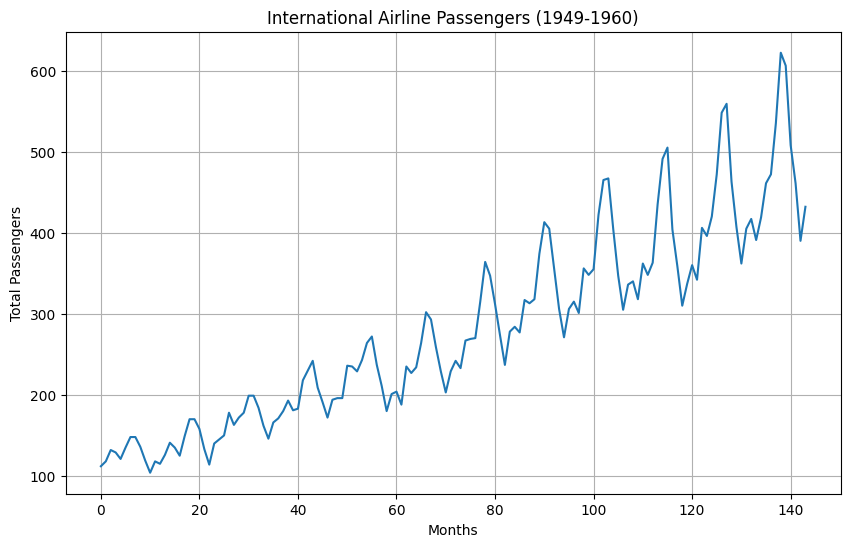

In [ ]:
# Step 2: Exploratory Data Analysis (EDA)

# Plot the entire time series dataset
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title("International Airline Passengers (1949-1960)")
plt.ylabel("Total Passengers")
plt.xlabel("Months")
plt.grid(True)
plt.show()

# Step 3: Data Preprocessing

In [ ]:
# Step 3: Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

# 1. Normalize the dataset (LSTMs are sensitive to the scale of input data)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# 2. Split into train and test sets
# With time series, we cannot split randomly. We must split sequentially.
train_size = int(len(data_normalized) * 0.67)
test_size = len(data_normalized) - train_size
train_data, test_data = data_normalized[0:train_size,:], data_normalized[train_size:len(data_normalized),:]

print("Training samples:", len(train_data))
print("Testing samples:", len(test_data))

# 3. Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 1
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)

# 4. Reshape input to be [samples, time steps, features] which is required for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Training samples: 96
Testing samples: 48
x_train shape: (94, 1, 1)
x_test shape: (46, 1, 1)


# Step 4: Modeling
---
In this step, we build the LSTM neural network that will learn to predict future passenger numbers. We use a Sequential model, which allows layers to be added one after another in a simple, linear stack.
First, we add an LSTM layer with 4 units, which is responsible for learning patterns over time. Its input shape matches our reshaped time-series data, allowing the model to understand one time step at a time.
Next, we add a Dense layer with 1 unit, which produces the final prediction: the passenger count for the next month.
Finally, we compile the model using the mean squared error loss function and the Adam optimizer, which helps the network learn efficiently. The model summary shows the structure and number of parameters the network will train.


In [ ]:
# Step 4: Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Define the LSTM model
model = Sequential()
# LSTM layer with 4 units, input shape matches our reshaped data
model.add(LSTM(4, input_shape=(1, look_back)))
# Dense output layer (1 unit because we are predicting 1 value)
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

# Step 5: Training
---
In this step, we train the LSTM model on the prepared training data. The model learns by repeatedly comparing its predictions to the actual values and adjusting its internal weights. We train for 50 epochs with a small batch size of 4, which helps the model learn patterns in the time series more effectively.
During training, the model records its loss (error) after each epoch. We then plot this loss curve to visually check if the model is learning well—loss should generally decrease over time.
This step teaches the model how to recognize the time-based patterns in the dataset so it can make accurate future predictions.

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0831
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0554
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0430
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161
Epoch 16/50
24/24 ━

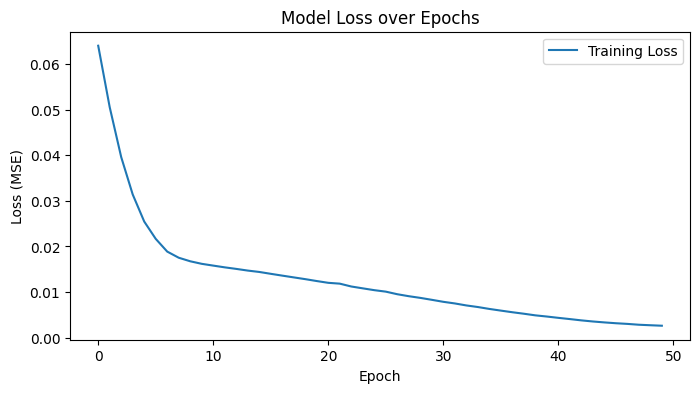

In [ ]:
# Step 5: Training
# Train the model
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=4,
    verbose=1
)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Step 6: Model Evaluation and Prediction
---
After training, we evaluate how well the model predicts passenger numbers. First, we use the model to generate predictions for both the training set and the test set. Since we scaled the data before training, we reverse the scaling to get the predictions back in the original passenger counts.
Next, we calculate the Root Mean Squared Error (RMSE), a standard metric that shows how far the predicted values are from the actual values on average. Lower RMSE means better predictions.
This step tells us how accurately the model has learned patterns in the data and how well it is likely to predict future passenger numbers.

In [ ]:
# Step 6: Model Evaluation and Prediction
import math
from sklearn.metrics import mean_squared_error

# make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions back to original scale (passengers count)
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = math.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} RMSE')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train Score: 26.04 RMSE
Test Score: 62.16 RMSE


# Step 7: Visualization
---
In this step, we create a visual comparison between the model’s predictions and the original passenger data. First, we align the training and test predictions with the correct time steps, leaving gaps (NaN) where no predictions exist.
Then, we plot the original data alongside the training and test predictions. This visualization helps us see how closely the model follows the true patterns in the dataset and where it may over- or under-predict.
Visualizing results is crucial for understanding model performance beyond numerical metrics—it lets us intuitively check how well the LSTM captures trends and seasonality in the time series.

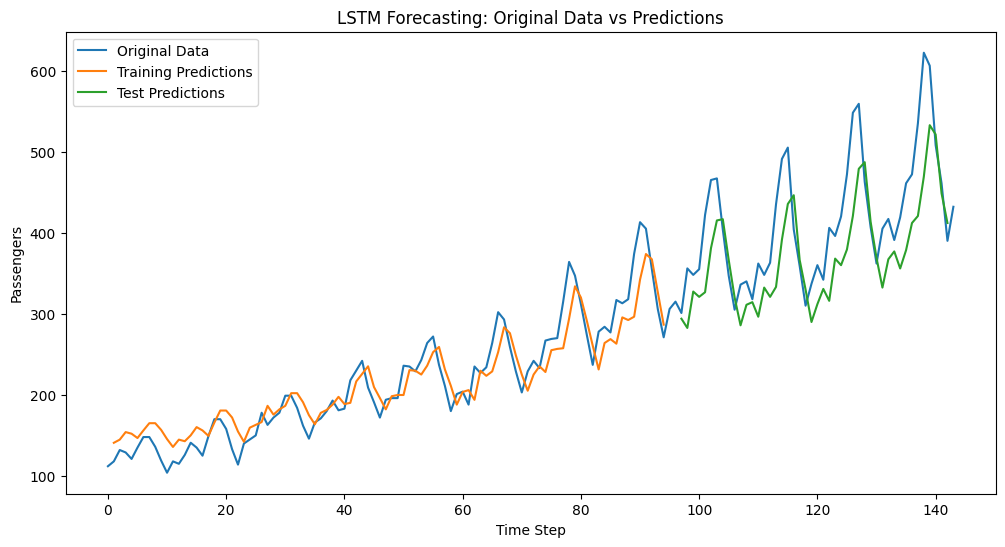

In [ ]:
# Step 7: Visualization of Results

# Shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(data) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_normalized), label='Original Data')
plt.plot(train_predict_plot, label='Training Predictions')
plt.plot(test_predict_plot, label='Test Predictions')
plt.title("LSTM Forecasting: Original Data vs Predictions")
plt.xlabel("Time Step")
plt.ylabel("Passengers")
plt.legend()
plt.show()

# Step 8: Deployment
---
In this step, we prepare the trained model for real-world use. First, we save the Keras model to a file so it can be loaded and used later without retraining. Optionally, we convert it to TensorFlow Lite (TFLite) format, which allows the model to run on mobile or edge devices.
Next, we create a Gradio interface, which provides a simple web-based tool for real-time forecasting. Users can enter the passenger count from the previous month, and the interface uses the trained LSTM to predict the next month’s passengers.
This step turns the trained model from a research project into an interactive, usable application, making predictions accessible to anyone in real time.

In [ ]:
# Step 8: Deployment
import gradio as gr
import numpy as np
import tensorflow as tf

# 1. Save the Keras model
model.save('airline_passengers_lstm.h5')
print("Model saved as airline_passengers_lstm.h5")

# 2. (Optional) Convert to TFLite for mobile deployment
# Note: LSTMs can be tricky with TFLite, but basic conversion often works.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# TFLite needs static shapes for some operations, enabling resource variables helps
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

with open('airline_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved as airline_model.tflite")

# 3. Create a Gradio Interface for real-time forecasting
def predict_next_month(last_value):
    try:
        # Prepare input: convert string to float
        value = float(last_value)

        # Normalize the input using the same scaler
        # Reshape to 2D array [samples, features]
        value_scaled = scaler.transform(np.array([[value]]))

        # Reshape for LSTM [samples, time steps, features]
        # (1, 1, 1) as look_back is 1
        input_data = value_scaled.reshape(1, 1, 1)

        # Predict
        prediction_scaled = model.predict(input_data)

        # Inverse transform to get actual passenger count
        prediction = scaler.inverse_transform(prediction_scaled)

        return f"Predicted Passengers: {int(prediction[0][0])}"
    except ValueError:
        return "Error: Please enter a valid number."
    except Exception as e:
        return f"Error: {str(e)}"

# Define Gradio interface
interface = gr.Interface(
    fn=predict_next_month,
    inputs=gr.Number(label=f"Enter Passengers for Previous Month (Look back = {look_back})"),
    outputs="text",
    title="Airline Passenger Forecaster (LSTM)",
    description="Enter the total international passengers for the previous month to forecast the next month."
)

# Launch the interface (share=True creates a public link)
interface.launch(share=True, debug=True)

Model saved as airline_passengers_lstm.h5
Saved artifact at '/tmp/tmprdiriejl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135756912440720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756912442832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756912443216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756912442064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135756912441296: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved as airline_model.tflite
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bfa69801bae349c287.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gr

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bfa69801bae349c287.gradio.live


# Step 9: Testing/Monitoring
---
In this final step, we verify that the saved model works correctly after deployment. We reload the trained model from the file to ensure it can be used independently of the training session.
Then, we pick a sample from the test set and feed it into the model to make a prediction. Since the data was scaled during preprocessing, we invert the scaling to compare the predicted passenger count with the actual value.
Finally, we calculate the difference between the prediction and the true value. This step confirms that the model produces accurate forecasts and helps monitor its performance before real-world use.

In [ ]:
# Step 9: Testing/Monitoring

# Reload the saved model to verify it works correctly
loaded_model = tf.keras.models.load_model('airline_passengers_lstm.h5')
print("Model loaded successfully.")

# Pick a sample from the test set to verify
sample_idx = 0
sample_input = x_test[sample_idx].reshape(1, 1, 1)
sample_actual = y_test[sample_idx]

# Predict with loaded model
pred_scaled = loaded_model.predict(sample_input)

# Invert scaling
pred_value = scaler.inverse_transform(pred_scaled)[0][0]
actual_value = scaler.inverse_transform([[sample_actual]])[0][0]

print(f"Sample Input (Scaled): {sample_input}")
print(f"Loaded Model Prediction: {pred_value:.2f}")
print(f"Actual Value: {actual_value:.2f}")

# Calculate simple error
diff = abs(pred_value - actual_value)
print(f"Difference: {diff:.2f}")

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Sample Input (Scaled): [[[0.4073359]]]
Loaded Model Prediction: 293.95
Actual Value: 301.00
Difference: 7.05
